## This script does segmentation of the fashion images to differentiate between (1) head, (2) body, (3) background. DeepLab v3 is used with resnet50 for this purpose.


## Imports

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
import re
import random
from tqdm import tqdm


# Python program to explain shutil.copyfile() method
 
# importing os module
import os
 
from sklearn.model_selection import train_test_split
# importing shutil module
import shutil

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize, RandomVerticalFlip, RandomHorizontalFlip, Normalize, CenterCrop

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


## Linking to drive

In [3]:
## Run once to link to google drive using GCP
#!sudo apt-get install google-drive-ocamlfuse
#!sudo add-apt-repository ppa:alessandro-strada/ppa
#!sudo apt-get update
#!sudo apt-get install google-drive-ocamlfuse

In [4]:
!google-drive-ocamlfuse -headless -id=553698332080-4ilebkr6tajj9d4on76a6sfjilo8dbob.apps.googleusercontent.com -secret=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

In [5]:
#Initializing google drive to a folder
import os
if not os.path.exists("./acv"):
  os.makedirs("./acv")

!google-drive-ocamlfuse acv

In [6]:
import os
os.chdir('/content/acv/Courses/EECS 6691 - Advanced Deep Learning/Deep Learning Project/Group Project/Codes/')

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/Courses/EECS 6691 - Advanced Deep Learning/Deep Learning Project/Group Project/Codes/')

## Setting up directories and loaders

In [8]:
#dir_input = '../Results/Segmentation/SAM_1_041623b/'
dir_input = '../DeepFashionMultimodal_Men/images/'
dir_desired = '../DeepFashionMultimodal_Men/segm/'

In [9]:
import os

lst = os.listdir(dir_input) # your directory path
number_files = len(lst)
print(number_files)

5437


In [10]:
#Checking through segmentation library
#Checking all listed files
list_input = []
list_desired = []
for root, dirs, files in os.walk(dir_desired):
   for file in files:
      list_desired.append(os.path.join(root, file))
      list_input.append(dir_input + file[:-9] + '.jpg') 

print(len(list_desired))
print(len(list_input))

1506
1506


In [11]:
#Splitting up the data
X_train, X_test, y_train, y_test = train_test_split(list_input, list_desired, test_size=0.2, random_state=42)

## Dataloader

In [12]:
#data = list(zip(X_train, y_train))
#random.shuffle(data)
#X_train, y_train = zip(*data)

In [13]:
labels_bg = [0] #Background
labels_head = [13, 14] #Head + Hair
labels_body = list(range(1,13)) + list(range(15,24)) #The rest

In [14]:
height = 1101
width = 750

class DataLoaderSegm(torch.utils.data.dataset.Dataset):
    def __init__(self, image_files, mask_files, mode):
        super(DataLoaderSegm, self).__init__()
        self.img_files = image_files
        self.label_files = mask_files
        self.mode = mode
        
        # Data augmentation and normalization for training
        # Just normalization for validation
        self.transforms = transforms.Compose([
                    transforms.Resize((height, width)),
                    transforms.ToTensor(),
                ])
        self.transforms_flip = transforms.Compose([
                    transforms.RandomHorizontalFlip(1),
                ])

    def __getitem__(self, index):
            img_path = self.img_files[index]
            label_path = self.label_files[index]

            image = Image.open(img_path)
            label = Image.open(label_path)

            # Concatenate image and label, to apply same transformation on both
            image_np = np.asarray(image)
            label_np = np.asarray(label)

            #Convert to 3 class
            label_np2 = np.zeros(label_np.shape, dtype=np.uint8)
            label_np2 = np.isin(label_np, labels_head)*1 + np.isin(label_np, labels_body)*2 

            new_shape = (image_np.shape[0], image_np.shape[1], image_np.shape[2] + 1)
            image_and_label_np = np.zeros(new_shape, image_np.dtype)
            image_and_label_np[:, :, 0:3] = image_np
            image_and_label_np[:, :, 3] = label_np2

            # Convert to PIL
            image_and_label = Image.fromarray(image_and_label_np)
            
            # Apply Transforms
            #if random.random()>0.5:
              #image_and_label = self.transforms_flip(image_and_label)
            image_and_label = self.transforms(image_and_label)

            # Extract image and label
            image = image_and_label[0:3, :, :]
            label = image_and_label[3, :, :].unsqueeze(0)

            # Normalize back from [0, 1] to [0, 255]
            label = label * 255
            #  Convert to int64 and remove second dimension
            label = label.long().squeeze()

            return image, label

    def __len__(self):
        return len(self.img_files)

In [15]:
FashionDataset={
    'train': DataLoaderSegm(X_train, y_train, 'train'),
    'val': DataLoaderSegm(X_test, y_test, 'val')
}

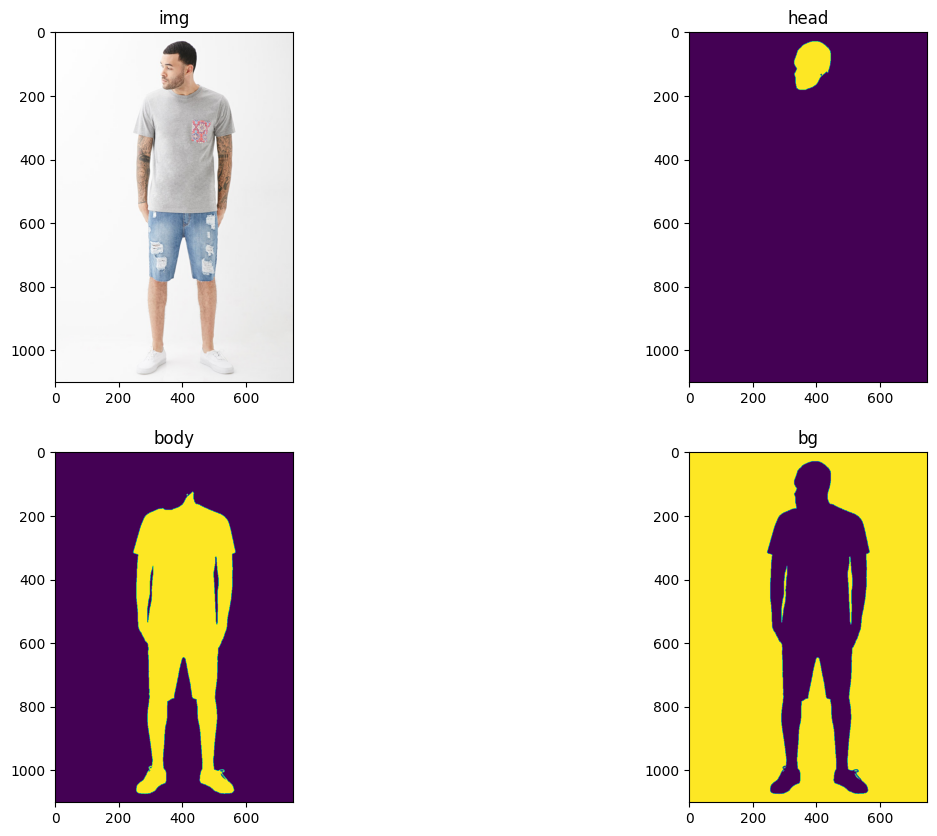

In [16]:
#Sample display
img, lab = FashionDataset['train'][0]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0,0].imshow(img.permute((1,2,0)))
axs[0,0].set_title('img')
axs[0,1].imshow(lab==1)
axs[0,1].set_title('head')
axs[1,0].imshow(lab==2)
axs[1,0].set_title('body')
axs[1,1].imshow(lab==0)
axs[1,1].set_title('bg')

plt.show()

## Training

In [17]:
def initialize_model(num_classes, keep_feature_extract=False, use_pretrained=True):
    """ DeepLabV3 pretrained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    """
    model_deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=use_pretrained, progress=True)
    model_deeplabv3.aux_classifier = None
    if keep_feature_extract:
        for param in model_deeplabv3.parameters():
            param.requires_grad = False

    input_size = img.shape
    model_deeplabv3.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, num_classes)

    return model_deeplabv3, input_size

In [18]:
import os
import torch
import numpy as np
import time
import copy
import cv2

def debug_export_before_forward(inputs, labels, idx):
    # im = inputs[0]*255;
    im = inputs[0];
    im = im.to('cpu').numpy()
    #im[0, :, :] = im[0, :, :] * 0.229 + 0.485
    #im[1, :, :] = im[1, :, :] * 0.224 + 0.456
    #im[2, :, :] = im[2, :, :] * 0.225 + 0.406
    im = im * 255
    im = im.astype(np.uint8)
    la = labels[0].to(torch.uint8).to('cpu').numpy()
    im = im.transpose([1, 2, 0])
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{idx:06}_im.png", im)
    cv2.imwrite(f"{idx:06}_la.png", la)


def iou(pred, target, n_classes = 3):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  # Ignore IoU for background class ("0")
  for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
    pred_inds = pred == cls
    target_inds = target == cls
    intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
    union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
    if union > 0:
        ious.append(float(intersection) / float(max(union, 1)))

  return np.array(ious)


def train_model(model, num_classes, dataloaders, criterion, optimizer, device, dest_dir, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_state_dict = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    counter = 0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou_means = []

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Security, skip this iteration if the batch_size is 1
                #if 1 == inputs.shape[0]:
                #    print("Skipping iteration because batch_size = 1")
                #    continue

                # Debug
                # debug_export_before_forward(inputs, labels, counter)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)['out']
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                iou_mean = iou(preds, labels, num_classes).mean()
                running_loss += loss.item() * inputs.size(0)
                running_iou_means.append(iou_mean)

                # Increment counter
                counter = counter + 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if running_iou_means is not None:
                epoch_acc = np.array(running_iou_means).mean()
            else:
                epoch_acc = 0.


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_state_dict = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            # Save current model every 25 epochs
            if 0 == epoch%25:
                current_model_path = os.path.join(dest_dir, f"checkpoint_{epoch:04}_DeepLabV3_Fashion.pth")
                print(f"Save current model : {current_model_path}")
                torch.save(model.state_dict(), current_model_path)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    return best_model_state_dict, val_acc_history 

In [19]:
# Initialize model
model_deeplabv3, input_size = initialize_model(num_classes=3, keep_feature_extract=False, use_pretrained=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_deeplabv3 = model_deeplabv3.to(device)

model_deeplabv3.load_state_dict(torch.load('../Results/Segmentation/DLv3_output/best_DeepLabV3_Fashion_Men.pth'))
model_deeplabv3.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

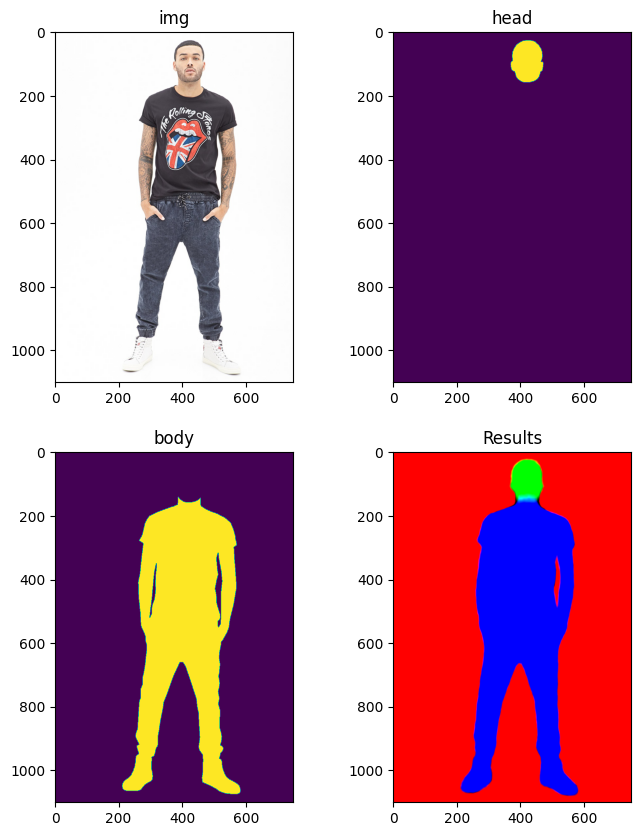

In [20]:
model_deeplabv3.eval()

im, lab = FashionDataset['val'][25]
outputs = model_deeplabv3(im.unsqueeze(0).to(device))['out']

#Sample display
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# Display the LR and HR images using matplotlib
axs[0,0].imshow(im.permute((1,2,0)))
axs[0,0].set_title('img')
axs[0,1].imshow(lab==1)
axs[0,1].set_title('head')
axs[1,0].imshow(lab==2)
axs[1,0].set_title('body')
axs[1,1].imshow(outputs.squeeze(0).permute((1,2,0)).detach().cpu())
axs[1,1].set_title('Results')

plt.show()


In [21]:
keep_feature_extract=False
num_classes = 3
dest_dir = '../Results/Segmentation/DLv3_output/'
weight = []

num_epochs = 10
batch_size = 2
learning_rate = 1e-4

In [22]:
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(FashionDataset[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

print("Initializing Model...")
'''
# Initialize model
model_deeplabv3, input_size = initialize_model(num_classes=num_classes, keep_feature_extract=keep_feature_extract, use_pretrained=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_deeplabv3 = model_deeplabv3.to(device)
'''

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_deeplabv3.parameters()
print("Params to learn:")
if keep_feature_extract:
    params_to_update = []
    for name, param in model_deeplabv3.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_deeplabv3.named_parameters():
        if param.requires_grad:
            print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)

# Setup the loss function
criterion = nn.CrossEntropyLoss(weight=(torch.FloatTensor(weight).to(device) if weight else None))

# Prepare output directory
Path(dest_dir).mkdir(parents=True, exist_ok=True)

print("Train...")

# Train and evaluate
model_deeplabv3_state_dict, hist = train_model(model_deeplabv3, num_classes, dataloaders_dict, criterion, optimizer_ft, device, dest_dir, num_epochs=num_epochs)

print("Save ...")
torch.save(model_deeplabv3_state_dict, os.path.join(dest_dir, "best_DeepLabV3_FashionMenv2.pth"))

Initializing Model...
Params to learn:
	 backbone.conv1.weight
	 backbone.bn1.weight
	 backbone.bn1.bias
	 backbone.layer1.0.conv1.weight
	 backbone.layer1.0.bn1.weight
	 backbone.layer1.0.bn1.bias
	 backbone.layer1.0.conv2.weight
	 backbone.layer1.0.bn2.weight
	 backbone.layer1.0.bn2.bias
	 backbone.layer1.0.conv3.weight
	 backbone.layer1.0.bn3.weight
	 backbone.layer1.0.bn3.bias
	 backbone.layer1.0.downsample.0.weight
	 backbone.layer1.0.downsample.1.weight
	 backbone.layer1.0.downsample.1.bias
	 backbone.layer1.1.conv1.weight
	 backbone.layer1.1.bn1.weight
	 backbone.layer1.1.bn1.bias
	 backbone.layer1.1.conv2.weight
	 backbone.layer1.1.bn2.weight
	 backbone.layer1.1.bn2.bias
	 backbone.layer1.1.conv3.weight
	 backbone.layer1.1.bn3.weight
	 backbone.layer1.1.bn3.bias
	 backbone.layer1.2.conv1.weight
	 backbone.layer1.2.bn1.weight
	 backbone.layer1.2.bn1.bias
	 backbone.layer1.2.conv2.weight
	 backbone.layer1.2.bn2.weight
	 backbone.layer1.2.bn2.bias
	 backbone.layer1.2.conv3.weight


100%|██████████| 602/602 [20:01<00:00,  2.00s/it]


train Loss: 0.0307 Acc: 0.9045


100%|██████████| 151/151 [02:17<00:00,  1.10it/s]


val Loss: 0.0331 Acc: 0.9060

Epoch 2/10
----------


100%|██████████| 602/602 [20:02<00:00,  2.00s/it]


train Loss: 0.0273 Acc: 0.9163


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0327 Acc: 0.9089

Epoch 3/10
----------


100%|██████████| 602/602 [20:02<00:00,  2.00s/it]


train Loss: 0.0256 Acc: 0.9213


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0285 Acc: 0.9172

Epoch 4/10
----------


100%|██████████| 602/602 [20:01<00:00,  2.00s/it]


train Loss: 0.0243 Acc: 0.9247


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0272 Acc: 0.9193

Epoch 5/10
----------


100%|██████████| 602/602 [20:02<00:00,  2.00s/it]


train Loss: 0.0233 Acc: 0.9288


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0258 Acc: 0.9227

Epoch 6/10
----------


100%|██████████| 602/602 [20:02<00:00,  2.00s/it]


train Loss: 0.0223 Acc: 0.9300


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0261 Acc: 0.9194

Epoch 7/10
----------


100%|██████████| 602/602 [20:02<00:00,  2.00s/it]


train Loss: 0.0217 Acc: 0.9318


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0227 Acc: 0.9264

Epoch 8/10
----------


100%|██████████| 602/602 [20:03<00:00,  2.00s/it]


train Loss: 0.0208 Acc: 0.9340


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0236 Acc: 0.9269

Epoch 9/10
----------


100%|██████████| 602/602 [20:01<00:00,  2.00s/it]


train Loss: 0.0203 Acc: 0.9351


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0252 Acc: 0.9268

Epoch 10/10
----------


100%|██████████| 602/602 [20:03<00:00,  2.00s/it]


train Loss: 0.0197 Acc: 0.9368


100%|██████████| 151/151 [01:30<00:00,  1.67it/s]


val Loss: 0.0249 Acc: 0.9266

Training complete in 216m 16s
Best val Acc: 0.926915
Save ...


In [23]:
halt

NameError: ignored

In [ ]:
import os

def check_files_existence(file_list):
    exists = []
    not_exists = []
    for file in tqdm(file_list):
        if os.path.exists(file):
            exists.append(file)
        else:
            not_exists.append(file)
    return exists, not_exists

#exists, not_exists = check_files_existence(list_desired)
#print("Files that exist:", exists)
#print("Files that do not exist:", not_exists)

exists, not_exists = check_files_existence(list_input)
print("Files that exist:", exists)
print("Files that do not exist:", not_exists)

import pandas as pd

df = pd.DataFrame(not_exists)

# Save the DataFrame to a CSV file
df.to_csv('data_lost2.csv', index=False)


In [ ]:
model_deeplabv3.eval()

In [ ]:
torch.save(model_deeplabv3.state_dict(), os.path.join(dest_dir, "best_DeepLabV3_Fashion3.pth"))

In [ ]:
outputs = model_deeplabv3(img.unsqueeze(0).to(device))['out']
plt.imshow(outputs.squeeze(0).permute([1,2,0]).detach().cpu())
plt.show()

In [ ]:
halt

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader



# Create a Google Cloud Storage bucket.
bucket_name = "my-bucket"

# Upload your files to the bucket.
for file_name in ["file1.txt", "file2.txt"]:
    blob = bucket.blob(file_name)
    blob.upload_from_filename(file_name)

# Create a `torch.utils.data.Dataset` class that loads the files from the bucket.
class MyDataset(Dataset):
    def __init__(self):
        self.files = [
            bucket.blob(file_name).download_as_text()
            for file_name in ["file1.txt", "file2.txt"]
        ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        return self.files[index]

# Create a `torch.utils.data.DataLoader` object that uses the `Dataset` class.
data_loader = DataLoader(MyDataset(), batch_size=32)

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
bucket_name = 'deep_fashion_multimodal'
!gsutil ls gs://{bucket_name}/DeepFashionMultimodal/
